# 0. Imports

In [1]:
import scipy
import numpy as np
import pandas as pd
#import boruta as bt
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import tree

from sklearn import metrics as mt
from sklearn import ensemble as en
from sklearn import linear_model as lm
from sklearn import kernel_ridge as kr
from sklearn import preprocessing as pp
from sklearn import neural_network as nn
from sklearn import model_selection as ms
from sklearn import gaussian_process as gp
from sklearn import cross_decomposition as cd

from statsmodels import api

In [2]:
def settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    #display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

settings()

def cramer_v(x, y):

    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = scipy.stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min( kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def ml_metrics(y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))

    return mae, mape, rmse

def cross_validation(models_performance_cv, num_folds, model_name, model, mm_production, x_train, y_train):

    kfold = ms.KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):

        # separate train folds and val fold
        x_train_fold = x_train.iloc[train_cv].copy()
        y_train_fold = y_train.iloc[train_cv].copy()

        x_val_fold = x_train.iloc[val_cv].copy()
        y_val_fold = y_train.iloc[val_cv].copy()

        # train model
        model_fit = model.fit(x_train_fold, y_train_fold)

        # predict values with trained model
        yhat_model = model_fit.predict(x_val_fold)
    
        #performance
        m_result = ml_error(model_name, mm_production.inverse_transform([y_val_fold]), mm_production.inverse_transform([yhat_model]))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

        print(f"{model_name} Fold {i} Finished")

        i+=1

    model_performance = pd.DataFrame({'Model Name': model_name,
                                       'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),}, index=[0])

    models_performance_cv = pd.concat([models_performance_cv, model_performance])
        
    return models_performance_cv

# 1. Data Exploration

In [3]:
df1 = pd.read_csv('dados_resultados.csv')

In [4]:
vo2_column = df1['VO2']
df1 = df1.drop(['VO2'], axis=1)
df1.insert(len(df1.columns), 'VO2', vo2_column)

In [5]:
df1.head()

,TestID,Time,RR,mean_RR,std_RR,rmssd,HR_mean,NN20,NN50,pNN20,pNN50,FC,Idade,Peso,Altura,VLF,LF,HF,VO2
0,1,-130.8400,0.6720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.2857,15,53.7000,161,NaN,NaN,NaN,5.6240
1,1,-130.1680,0.6720,0.6720,0.0000,0.0000,89.2857,0.0000,0.0000,0.0000,0.0000,89.2857,15,53.7000,161,0.0000,0.0000,0.0000,5.6240
2,1,-129.5360,0.6320,0.6587,0.0231,0.0283,91.0931,1.0000,0.0000,50.0000,0.0000,94.9367,15,53.7000,161,0.0000,0.0000,0.0000,5.6115
3,1,-128.8240,0.7120,0.6720,0.0327,0.0516,89.2857,2.0000,1.0000,66.6667,33.3333,84.2697,15,53.7000,161,0.0000,0.0000,0.0000,5.6115
4,1,-127.9480,0.8760,0.7128,0.0955,0.0934,84.1751,3.0000,2.0000,75.0000,50.0000,68.4932,15,53.7000,161,0.0000,0.0000,0.0000,5.6115


In [6]:
df1.columns

Index(['TestID', 'Time', 'RR', 'mean_RR', 'std_RR', 'rmssd', 'HR_mean', 'NN20',
       'NN50', 'pNN20', 'pNN50', 'FC', 'Idade', 'Peso', 'Altura', 'VLF', 'LF',
       'HF', 'VO2'],
      dtype='object')

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 50914
Number of Cols: 19


In [8]:
df1.isna().sum()

TestID      0
Time        0
RR          0
mean_RR    18
std_RR     18
rmssd      18
HR_mean    18
NN20       18
NN50       18
pNN20      18
pNN50      18
FC          0
Idade       0
Peso        0
Altura      0
VLF        18
LF         18
HF         18
VO2         0
dtype: int64

In [9]:
df1 = df1.dropna()

In [10]:
df1.dtypes

TestID       int64
Time       float64
RR         float64
mean_RR    float64
std_RR     float64
rmssd      float64
HR_mean    float64
NN20       float64
NN50       float64
pNN20      float64
pNN50      float64
FC         float64
Idade        int64
Peso       float64
Altura       int64
VLF        float64
LF         float64
HF         float64
VO2        float64
dtype: object

In [11]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [12]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(numerical_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(numerical_attributes.apply(np.std)).T
d2 = pd.DataFrame(numerical_attributes.apply(min)).T
d3 = pd.DataFrame(numerical_attributes.apply(max)).T
d4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,TestID,1.0000,18.0000,17.0000,9.4340,10.0000,5.0494,0.0018,-1.2055
1,Time,-219.1440,1504.0560,1723.2000,540.4197,530.0700,386.1224,0.1855,-0.7093
2,RR,0.2520,30.5000,30.2480,0.4435,0.4120,0.2125,74.6056,9257.0596
3,mean_RR,0.4066,1.1160,0.7094,0.5439,0.5089,0.1107,1.2488,1.0552
4,std_RR,0.0000,1.7274,1.7274,0.1781,0.1378,0.1757,4.5032,23.4341
5,rmssd,0.0000,2.4526,2.4526,0.1263,0.0398,0.2756,4.3294,21.0646
6,HR_mean,53.7634,147.5646,93.8012,114.2419,117.9100,19.7599,-0.5459,-0.6001
7,NN20,0.0000,303.0000,303.0000,190.5759,195.5000,45.7752,-1.3073,3.3427
8,NN50,0.0000,173.0000,173.0000,93.5732,100.0000,36.3991,-0.0820,-0.4383
9,pNN20,0.0000,100.0000,100.0000,22.9538,14.4277,20.4387,1.6886,1.9558


In [82]:
df1.sort_values('RR', ascending=False).head(100)

,TestID,Time,RR,mean_RR,std_RR,rmssd,HR_mean,NN20,NN50,pNN20,pNN50,FC,Idade,Peso,Altura,VLF,LF,HF,VO2
43826,16,75.8200,30.5000,0.8099,1.7274,1.7326,74.0839,174.0000,61.0000,58.5859,20.5387,1.9672,16,70.4000,182,0.0000,0.0000,0.0000,17.6674
17700,6,1028.8720,16.8720,0.4731,0.3554,0.3246,126.8331,230.0000,117.0000,8.9634,4.5596,3.5562,17,65.6000,169,0.0000,0.0000,0.1465,12.4816
21535,8,581.2520,16.7120,0.5055,0.4534,0.4251,118.6894,237.0000,167.0000,15.6850,11.0523,3.5902,15,51.2000,165,0.0000,0.0000,0.0000,34.4335
38168,14,-37.8080,6.5480,0.8906,0.4970,0.5129,67.3733,112.0000,72.0000,81.1594,52.1739,9.1631,13,62.3000,171,0.0000,0.0000,0.0000,9.3767
11920,5,80.9480,5.3080,0.6879,0.2829,0.2559,87.2186,175.0000,98.0000,46.0526,25.7895,11.3037,17,76.4000,186,0.0000,0.0000,0.0000,15.4620
40947,15,-93.8240,1.2440,0.8327,0.1359,0.1158,72.0555,82.0000,50.0000,75.2294,45.8716,48.2315,13,63.5000,172,0.0000,0.0000,0.0000,5.9107
40931,15,-108.7320,1.2280,0.8158,0.1186,0.0931,73.5448,66.0000,36.0000,70.9677,38.7097,48.8599,13,63.5000,172,0.0000,0.0000,0.0000,10.5157
40941,15,-99.4440,1.2040,0.8267,0.1292,0.1059,72.5784,76.0000,45.0000,73.7864,43.6893,49.8339,13,63.5000,172,0.0000,0.0000,0.0000,7.7520
20071,8,-139.3360,1.1720,0.9117,0.1147,0.1299,65.8135,44.0000,35.0000,93.6170,74.4681,51.1945,15,51.2000,165,0.0000,0.0000,0.0000,4.1552
38109,14,-96.3880,1.1680,0.8151,0.1131,0.1163,73.6106,62.0000,35.0000,78.4810,44.3038,51.3699,13,62.3000,171,0.0000,0.0000,0.0000,4.9832


In [14]:
df1[['TestID']].value_counts()

TestID
4         3693
12        3647
13        3636
5         3593
3         3442
11        3141
16        2839
9         2822
14        2807
15        2690
6         2682
10        2634
18        2570
1         2402
7         2206
8         2120
2         1999
17        1973
Name: count, dtype: int64

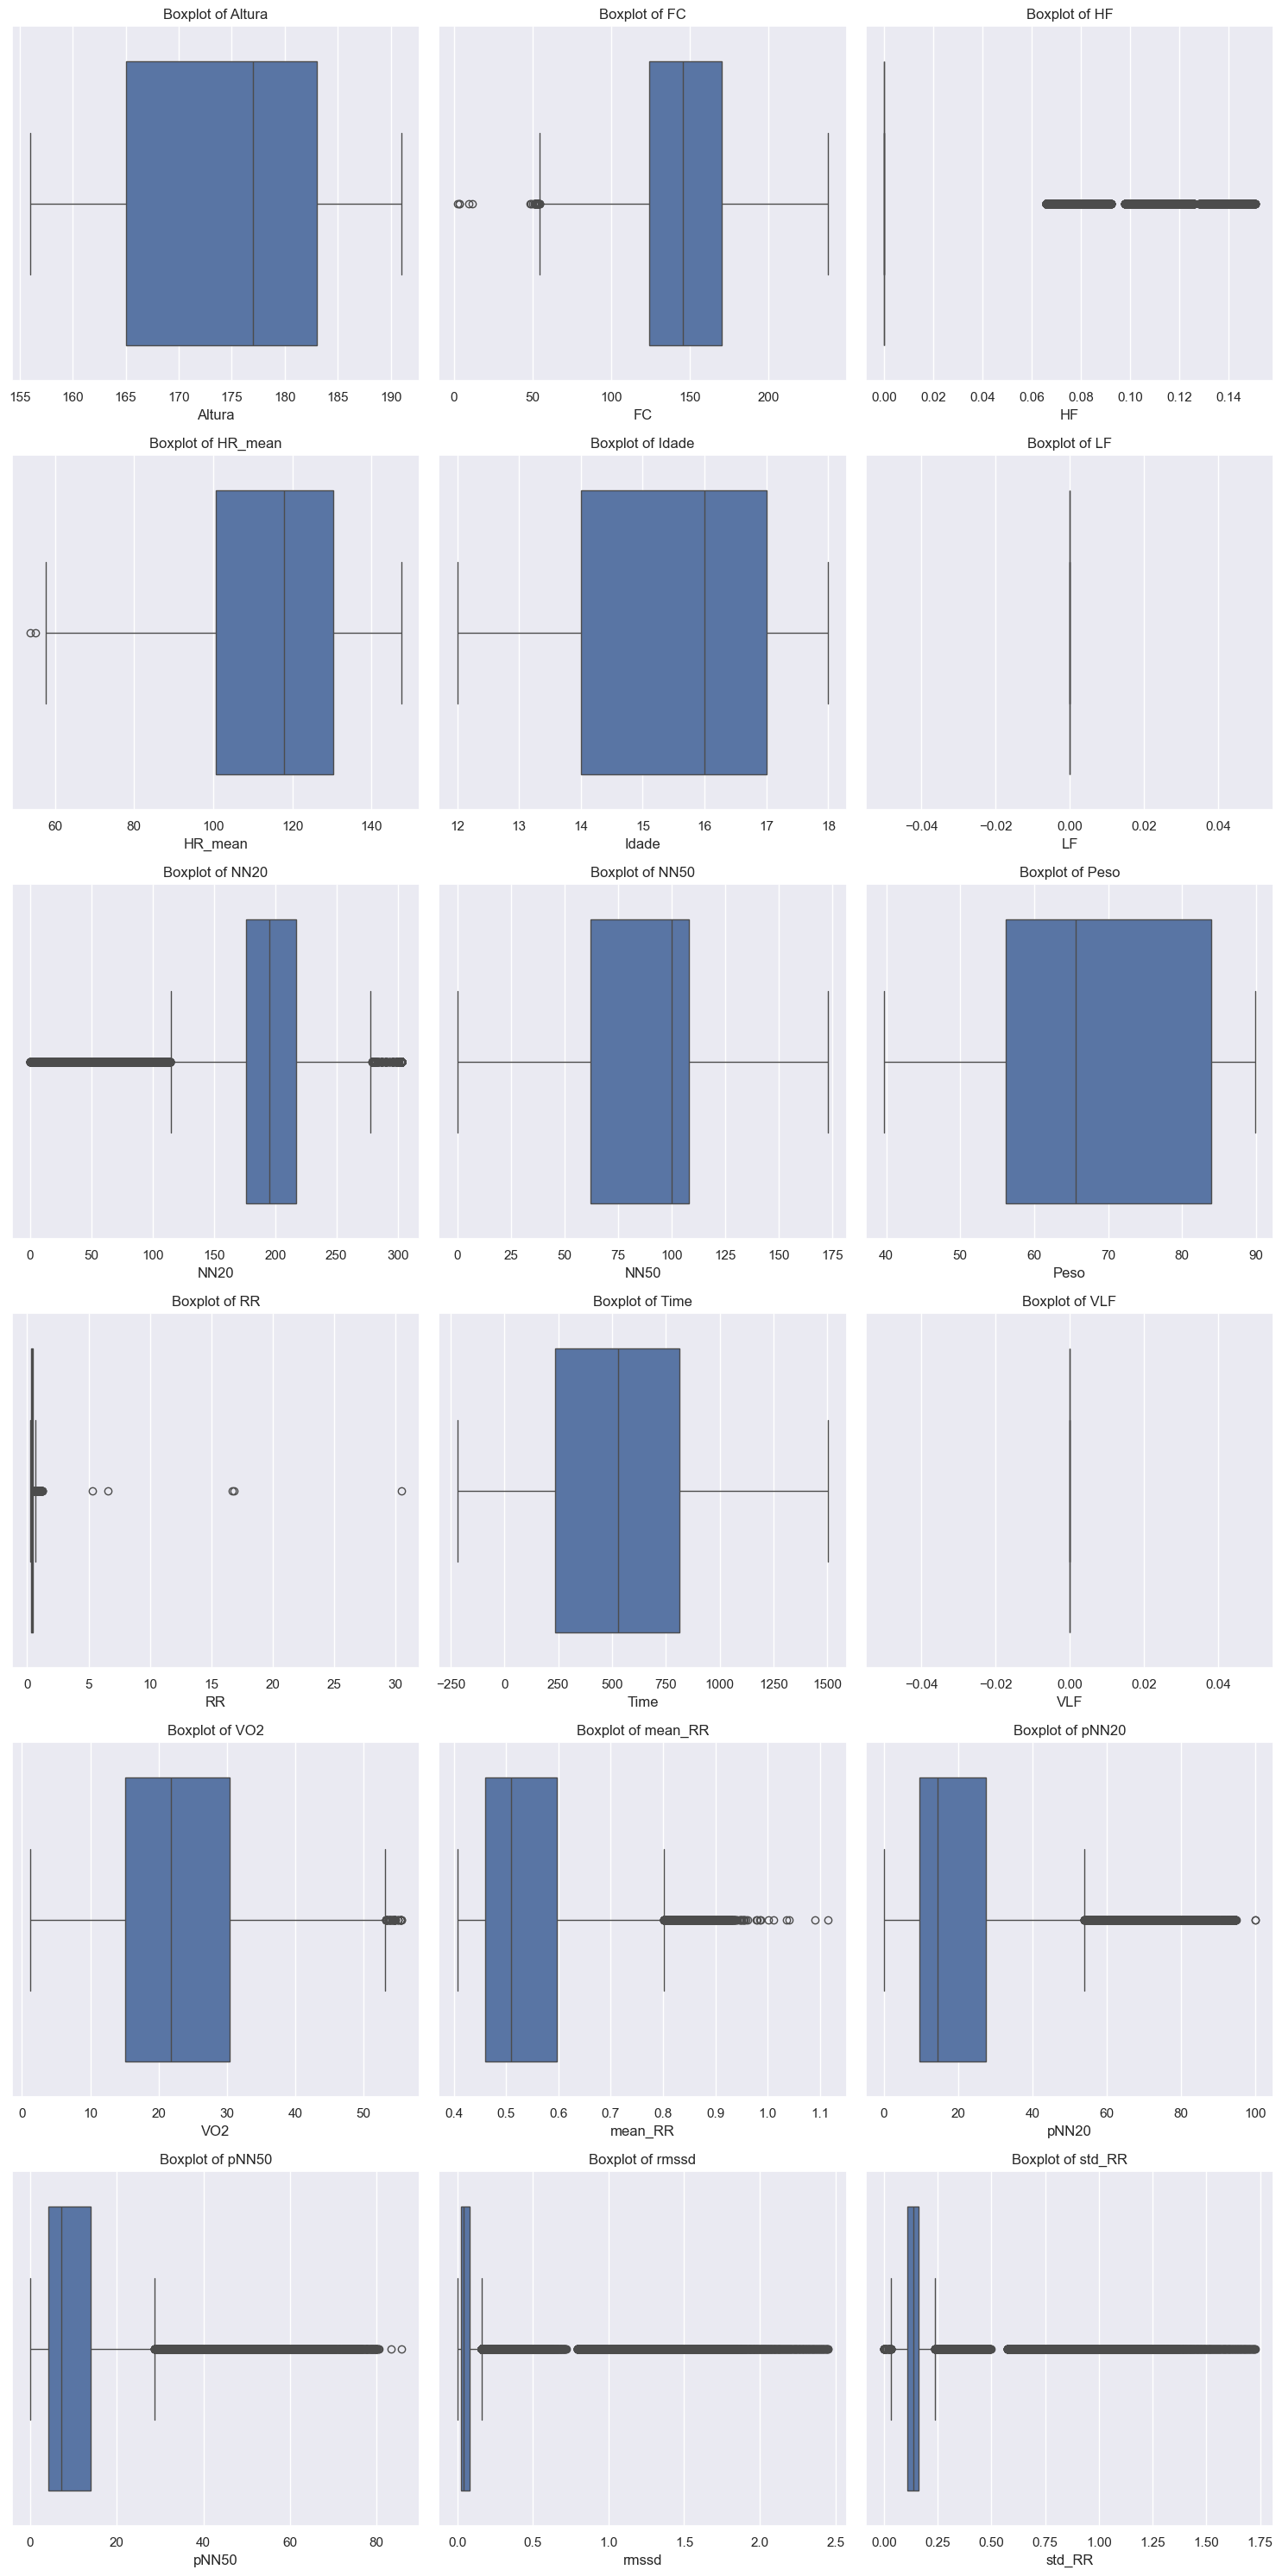

In [15]:
columns_to_plot = df1.columns.difference(['TestID'])
num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3 > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    sns.boxplot(data=df1, x=column, ax=axes[row, col])
    axes[row, col].set_title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

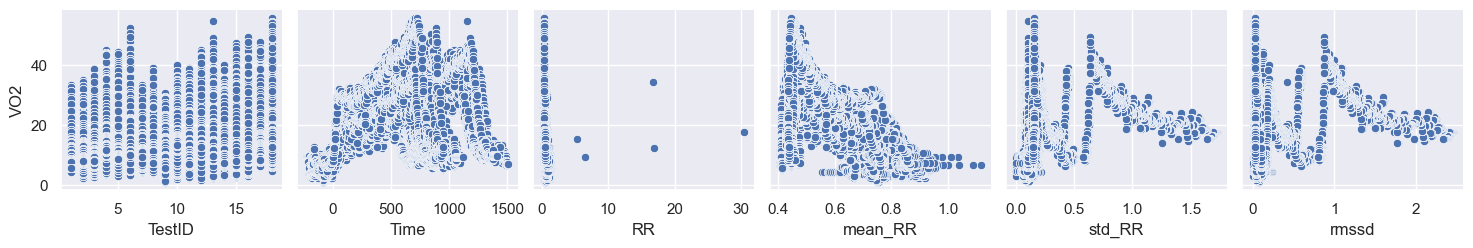

In [16]:
sns.pairplot(df1, y_vars='VO2', x_vars=['TestID', 'Time', 'RR', 'mean_RR', 'std_RR', 'rmssd']);

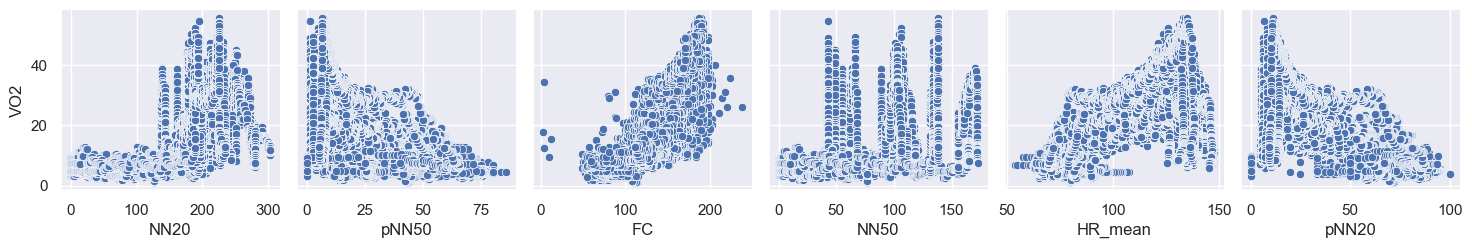

In [17]:
sns.pairplot(df1, y_vars='VO2', x_vars={'HR_mean', 'NN20', 'NN50', 'pNN20', 'pNN50', 'FC'});

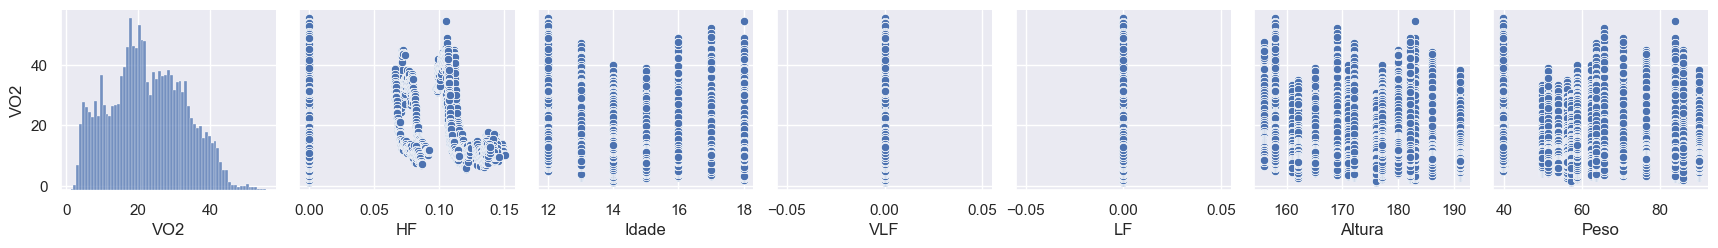

In [18]:
sns.pairplot(df1, y_vars='VO2', x_vars={'Idade', 'Peso', 'Altura', 'VLF', 'LF', 'HF', 'VO2'});

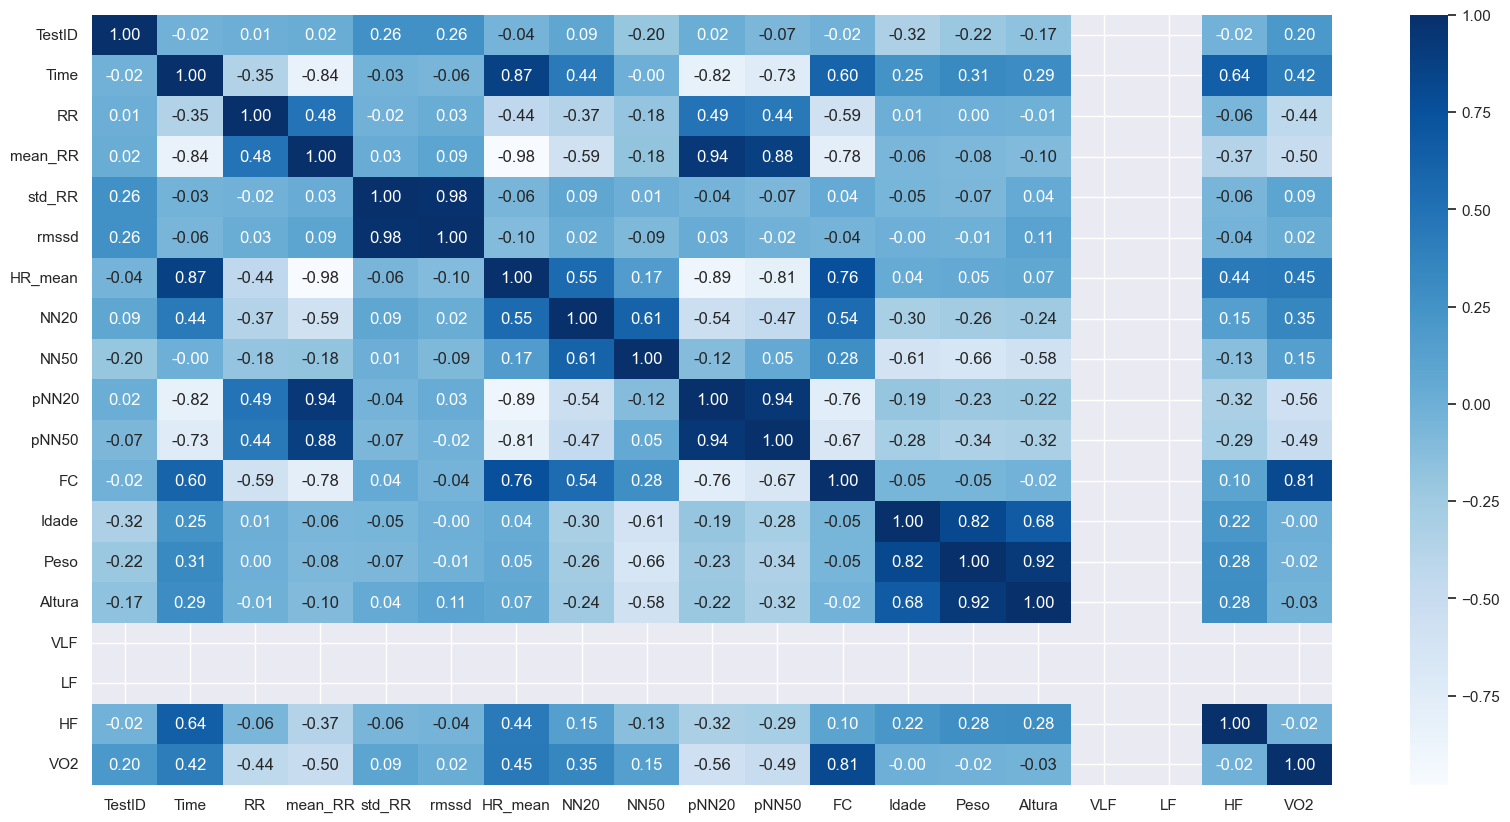

In [19]:

correlation = df1.corr(method='pearson');
sns.heatmap(correlation, cmap="Blues", annot=True, fmt='.2f');

# 2. Split and Variables Exploration

In [20]:
df2 = df1.copy()

In [21]:
x = df2[['TestID', 'Time', 'FC', 'Idade', 'Peso', 'Altura']].copy()
y = df2['VO2'].copy()

In [22]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.20)

df2_train = pd.concat([x_train, y_train], axis=1)
df2_test = pd.concat([x_test, y_test], axis=1)

In [23]:
mms_TestID = pp.MinMaxScaler()
mms_Time = pp.MinMaxScaler()
mms_FC = pp.MinMaxScaler()
mms_Idade = pp.MinMaxScaler()
mms_Peso = pp.MinMaxScaler()
mms_Altura = pp.MinMaxScaler()

df2_train['TestID'] = mms_TestID.fit_transform(df2_train[['TestID']].values)
df2_train['Time'] = mms_Time.fit_transform(df2_train[['Time']].values)
df2_train['FC'] = mms_FC.fit_transform(df2_train[['FC']].values)
df2_train['Idade'] = mms_Idade.fit_transform(df2_train[['Idade']].values)
df2_train['Peso'] = mms_Peso.fit_transform(df2_train[['Peso']].values)
df2_train['Altura'] = mms_Altura.fit_transform(df2_train[['Altura']].values)

mms_VO2 = pp.MinMaxScaler()
df2_train['VO2'] = mms_VO2.fit_transform(df2_train[['VO2']].values)

In [24]:
df2_test['TestID'] = mms_TestID.transform(df2_test[['TestID']].values)
df2_test['Time'] = mms_Time.transform(df2_test[['Time']].values)
df2_test['FC'] = mms_FC.transform(df2_test[['FC']].values)
df2_test['Idade'] = mms_Idade.transform(df2_test[['Idade']].values)
df2_test['Peso'] = mms_Peso.transform(df2_test[['Peso']].values)
df2_test['Altura'] = mms_Altura.transform(df2_test[['Altura']].values)

df2_test['VO2'] = mms_VO2.transform(df2_test[['VO2']].values)

In [25]:
df3_train = df2_train.copy()
df3_test = df2_test.copy()

In [26]:
x_train = df3_train.drop(['VO2'], axis=1)
y_train = df3_train['VO2'].values.ravel()

x_test = df3_test.drop(['VO2'], axis=1)
y_test = df3_test['VO2'].values.ravel()

In [27]:
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [28]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Features Ranking:")
df = pd.DataFrame()
for i, j, k in zip(x_train, rf.feature_importances_, range(len(rf.feature_importances_))):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[k])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

columns_selected_tree_importance = ['FC', 'Time', 'TestID', 'Peso', 'Idade', 'Altura']


Features Ranking:
  feature  importance
2      FC      0.6042
1    Time      0.2140
0  TestID      0.0785
4    Peso      0.0501
3   Idade      0.0313
5  Altura      0.0219


# 3. Training

In [29]:
lr = lm.LinearRegression().fit(x_train, y_train)
yhat_lr = lr.predict(x_test)
lr_result = ml_error('LinearRegression', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lr]))
lr_result

,Model Name,MAE,MAPE,RMSE
0,LinearRegression,4.2234,0.2647,5.3223


In [30]:
rr = lm.Ridge().fit(x_train, y_train)
yhat_rr = rr.predict(x_test)
rr_result = ml_error('Ridge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rr]))
rr_result

,Model Name,MAE,MAPE,RMSE
0,Ridge,4.2230,0.2646,5.3218


In [31]:
la = lm.Lasso().fit(x_train, y_train)
yhat_la = la.predict(x_test)
la_result = ml_error('Lasso', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_la]))
la_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,8.6447,0.6535,10.4625


In [32]:
enet = lm.ElasticNet().fit(x_train, y_train)
yhat_enet = enet.predict(x_test)
enet_result = ml_error('ElasticNet', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_enet]))
enet_result

,Model Name,MAE,MAPE,RMSE
0,ElasticNet,8.6447,0.6535,10.4625


In [33]:
brr = lm.BayesianRidge().fit(x_train, y_train)
yhat_brr = brr.predict(x_test)
brr_result = ml_error('BayesianRidge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_brr]))
brr_result

,Model Name,MAE,MAPE,RMSE
0,BayesianRidge,4.2234,0.2647,5.3223


In [34]:
lla = lm.LassoLars().fit(x_train, y_train)
yhat_lla = lla.predict(x_test)
lla_result = ml_error('LassoLars', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lla]))
lla_result

,Model Name,MAE,MAPE,RMSE
0,LassoLars,8.6447,0.6535,10.4625


In [35]:
pr = api.GLM(y_train, x_train, family=api.families.Poisson()).fit()
yhat_pr = pr.predict(x_test)
pr_result = ml_error('Poisson', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_pr]))
pr_result

,Model Name,MAE,MAPE,RMSE
0,Poisson,10.1563,0.7987,12.6634


In [36]:
gr = api.GLM(y_train, x_train, family=api.families.Gamma()).fit()
yhat_gr = gr.predict(x_test)
gr_result = ml_error('Gamma', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gr]))
gr_result

c:\Users\matheus.andrade.N305-3012153\anaconda3\envs\ecg\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


,Model Name,MAE,MAPE,RMSE
0,Gamma,10.8083,0.8638,13.8506


In [37]:
#svmr = svm.SVR(verose=True).fit(x_train, y_train)
#yhat_svmr = svmr.predict(x_test)
#svmr_result = ml_error('SVM', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_svmr]))
#svmr_result

In [38]:
tr = tree.DecisionTreeRegressor(random_state=42).fit(x_train, y_train)
yhat_tr = tr.predict(x_test)
tr_result = ml_error('DecisionTreeRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_tr]))
tr_result

,Model Name,MAE,MAPE,RMSE
0,DecisionTreeRegressor,0.3988,0.0228,1.0154


In [39]:
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_rf = rf.predict(x_test)
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4484,0.0252,0.8142


In [40]:
gb = en.GradientBoostingRegressor(random_state=42, verbose=0).fit(x_train, y_train)
yhat_gb = gb.predict(x_test)
gb_result = ml_error('GradientBoostingRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gb]))
gb_result

,Model Name,MAE,MAPE,RMSE
0,GradientBoostingRegressor,1.8338,0.1072,2.4716


In [41]:
ab = en.AdaBoostRegressor(random_state=42).fit(x_train, y_train)
yhat_ab = ab.predict(x_test)
ab_result = ml_error('AdaBoostRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_ab]))
ab_result

,Model Name,MAE,MAPE,RMSE
0,AdaBoostRegressor,3.3191,0.2103,4.0895


In [42]:
bag = en.BaggingRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_bag = bag.predict(x_test)
bag_result = ml_error('BaggingRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_bag]))
bag_result

,Model Name,MAE,MAPE,RMSE
0,BaggingRegressor,0.4673,0.0266,0.8507


In [43]:
etr = en.ExtraTreesRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_etr = etr.predict(x_test)
etr_result = ml_error('ExtraTreesRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_etr]))
etr_result

,Model Name,MAE,MAPE,RMSE
0,ExtraTreesRegressor,0.5148,0.0282,0.9217


In [44]:
xgbm = xgb.XGBRegressor(random_state=42, verbosity=0, device='cuda').fit(x_train, y_train)
yhat_xgbm = xgbm.predict(x_test)
xgbm_result = ml_error('XGBRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_xgbm]))
xgbm_result

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,1.1076,0.0614,1.5406


In [45]:
lgbm = lgb.LGBMRegressor(random_state=42, verbosity=0, n_jobs=-1).fit(x_train, y_train)
yhat_lgbm = lgbm.predict(x_test)
lgbm_result = ml_error('LGBMRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lgbm]))
lgbm_result

,Model Name,MAE,MAPE,RMSE
0,LGBMRegressor,1.3076,0.0736,1.7891


In [46]:
omp = lm.OrthogonalMatchingPursuit().fit(x_train, y_train)
yhat_omp = omp.predict(x_test)
omp_result = ml_error('OrthogonalMatchingPursuit', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_omp]))
omp_result

,Model Name,MAE,MAPE,RMSE
0,OrthogonalMatchingPursuit,4.9168,0.2871,6.1509


In [47]:
lars = lm.Lars().fit(x_train, y_train)
yhat_lars = lars.predict(x_test)
lars_result = ml_error('Lars', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lars]))
lars_result

,Model Name,MAE,MAPE,RMSE
0,Lars,4.2234,0.2647,5.3223


In [48]:
#gpr = gp.GaussianProcessRegressor().fit(x_train, y_train)
#yhat_gpr = gpr.predict(x_test)
#gpr_result = ml_error('GaussianProcessRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gpr]))
#gpr_result

In [49]:
nnet = nn.MLPRegressor().fit(x_train, y_train)
yhat_nnet = nnet.predict(x_test)
nnet_result = ml_error('MLPRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_nnet]))
nnet_result

,Model Name,MAE,MAPE,RMSE
0,MLPRegressor,1.9499,0.1186,2.6233


In [50]:
#krr = kr.KernelRidge().fit(x_train, y_train)
#yhat_krr = krr.predict(x_test)
#krr_result = ml_error('KernelRidge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_krr]))
#krr_result

In [51]:
pls = cd.PLSRegression().fit(x_train, y_train)
yhat_pls = pls.predict(x_test)
pls_result = ml_error('PLSRegression', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_pls]))
pls_result

,Model Name,MAE,MAPE,RMSE
0,PLSRegression,4.7217,0.2897,5.9088


# 4. Cross Validation

In [52]:
x_train_cv = df3_train.drop(['VO2'], axis=1)
y_train_cv = df3_train['VO2']

In [53]:
rf_cv = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1)
bg_cv = en.BaggingRegressor(random_state=42, verbose=0, n_jobs=-1)
et_cv = en.ExtraTreesRegressor(random_state=42, verbose=0, n_jobs=-1)

In [54]:
models_performance_cv = pd.DataFrame({'Model Name':[], "MAE CV":[], "MAPE CV":[], "RMSE CV":[]})
models_performance_cv = cross_validation(models_performance_cv, 5, 'RandomForestRegressor', rf_cv, mms_VO2, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'BaggingRegressor', bg_cv, mms_VO2, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'ExtraTreesRegressor', et_cv, mms_VO2, x_train_cv, y_train_cv)

models_performance_cv

RandomForestRegressor Fold 1 Finished
RandomForestRegressor Fold 2 Finished
RandomForestRegressor Fold 3 Finished
RandomForestRegressor Fold 4 Finished
RandomForestRegressor Fold 5 Finished
BaggingRegressor Fold 1 Finished
BaggingRegressor Fold 2 Finished
BaggingRegressor Fold 3 Finished
BaggingRegressor Fold 4 Finished
BaggingRegressor Fold 5 Finished
ExtraTreesRegressor Fold 1 Finished
ExtraTreesRegressor Fold 2 Finished
ExtraTreesRegressor Fold 3 Finished
ExtraTreesRegressor Fold 4 Finished
ExtraTreesRegressor Fold 5 Finished


,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,0.51 +/- 0.0,0.03 +/- 0.0,0.87 +/- 0.01
0,BaggingRegressor,0.53 +/- 0.01,0.03 +/- 0.0,0.92 +/- 0.02
0,ExtraTreesRegressor,0.57 +/- 0.0,0.03 +/- 0.0,0.97 +/- 0.02


In [115]:
# from optuna import create_study, Trial
# from optuna.samplers import TPESampler                  

# def objective(trial: Trial):

#     n_estimators = trial.suggest_int("n_estimators", 10, 50, step=10)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=2)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5, step=1)
#     bootstrap = trial.suggest_categorical("bootstrap", [True, False])
#     criterion = trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])

#     print("Training Random Forest Regressor with hyperparameters: ", n_estimators, min_samples_split, min_samples_leaf, bootstrap, criterion)
    
#     # Instantiate Random Forest Regressor with hyperparameters
#     rf = en.RandomForestRegressor(n_jobs=-1, 
#                                   random_state=42,
#                                   n_estimators=n_estimators,
#                                   min_samples_split=min_samples_split,
#                                   min_samples_leaf=min_samples_leaf,
#                                   bootstrap=bootstrap,
#                                   criterion=criterion).fit(x_train, y_train)

#     yhat_rf = rf.predict(x_test)

#     mae, mape, rmse = ml_metrics(mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))

#     new_row = {'n_estimators': n_estimators, 
#                'min_samples_split': min_samples_split, 
#                'min_samples_leaf': min_samples_leaf, 
#                'bootstrap': bootstrap, 
#                'criterion': criterion, 
#                'mae': mae,
#                'mape': mape,
#                'rmse': rmse}

#     global results_df
    
#     results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

#     print(f"MAE: {mae}, MAPE: {mape}, RMSE: {rmse}")

#     return rmse

# results_df = pd.DataFrame(columns=['n_estimators', 'min_samples_split', 'min_samples_leaf', 'bootstrap', 'criterion', 'rmse'])

# sampler = TPESampler(seed=42)
# study = create_study(direction="minimize", sampler=sampler) 
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_result = study.best_value

# print("Best Hyperparameters:", best_params)
# print("Best Result:", best_result)

In [72]:
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42).fit(x_train, y_train)

yhat_rf = rf.predict(x_test)

rf_result = ml_error('Random Forest', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,0.4484,0.0252,0.8142


In [101]:
df4_test = df2_test.copy()

In [102]:
df4_test['TestID'] = mms_TestID.inverse_transform(df2_test[['TestID']].values)
df4_test['Time'] = mms_Time.inverse_transform(df2_test[['Time']].values)
df4_test['FC'] = mms_FC.inverse_transform(df2_test[['FC']].values)
df4_test['Idade'] = mms_Idade.inverse_transform(df2_test[['Idade']].values)
df4_test['Peso'] = mms_Peso.inverse_transform(df2_test[['Peso']].values)
df4_test['Altura'] = mms_Altura.inverse_transform(df2_test[['Altura']].values)

df4_test['VO2'] = mms_VO2.inverse_transform(df2_test[['VO2']].values)

In [103]:
df4_test['VO2_predicted'] = mms_VO2.inverse_transform(np.array([yhat_rf]).reshape(-1, 1))

In [104]:
df4_test.head()

,TestID,Time,FC,Idade,Peso,Altura,VO2,VO2_predicted
11786,5.0000,5.6760,102.7397,17.0000,76.4000,186.0000,8.8311,8.3934
25636,10.0000,227.7840,126.0504,14.0000,58.8000,177.0000,17.7886,17.4658
26687,10.0000,625.5440,185.1852,14.0000,58.8000,177.0000,33.7699,32.2860
4985,3.0000,186.4920,109.4891,16.0000,89.9000,191.0000,12.7893,12.7528
34793,13.0000,71.8680,106.3830,18.0000,83.9000,183.0000,16.0160,15.7210


In [105]:
df4_test['error'] = df4_test['VO2'] - df4_test['VO2_predicted']

C:\Users\matheus.andrade.N305-3012153\AppData\Local\Temp\ipykernel_5324\4268731137.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4_test['error']);


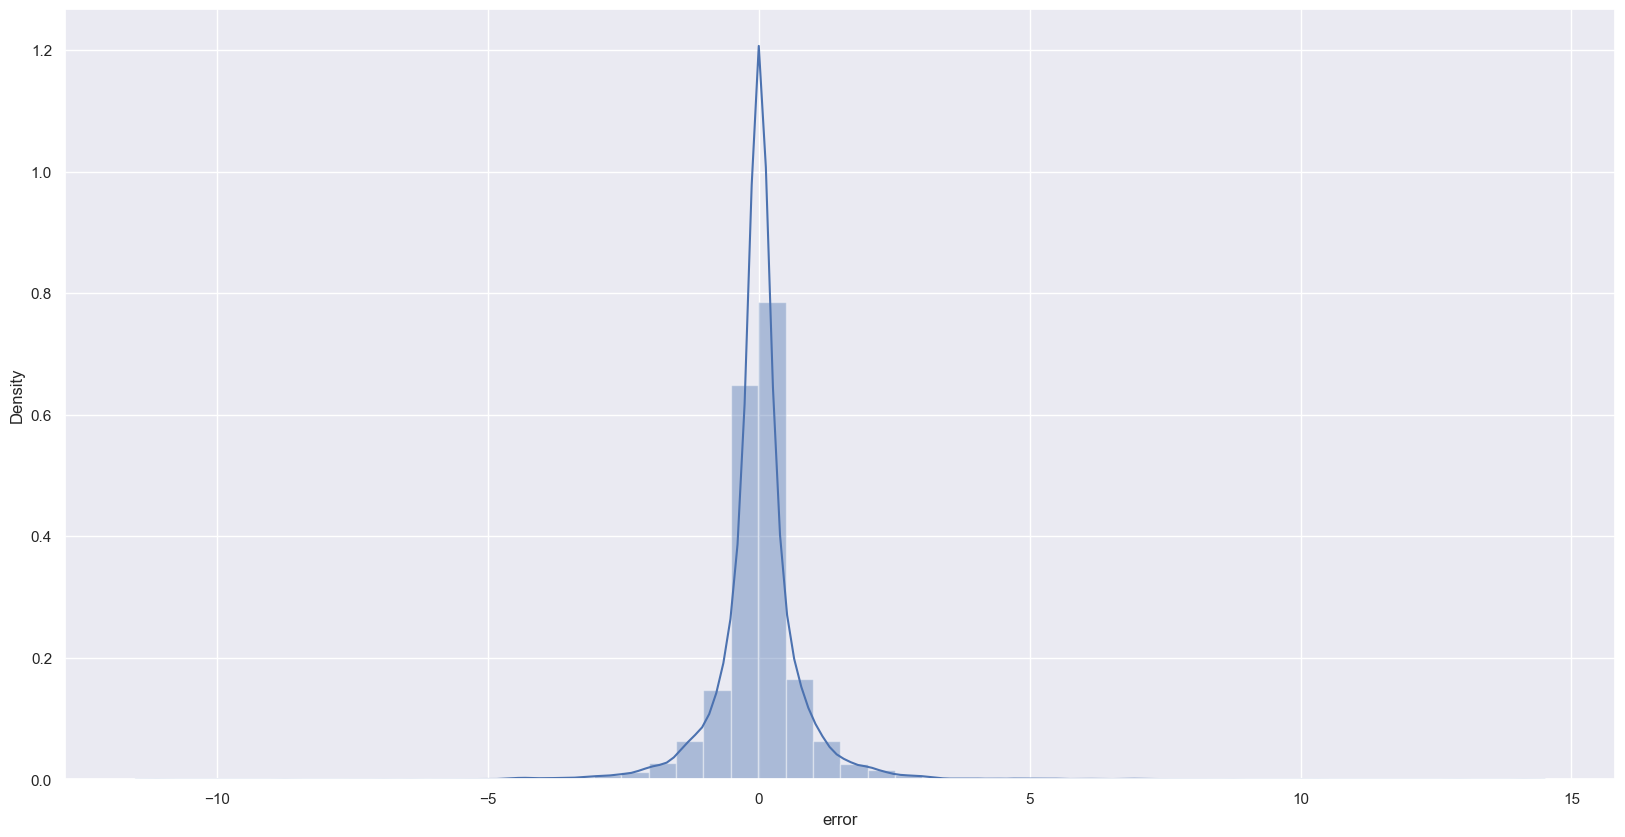

In [106]:
sns.distplot(df4_test['error']);

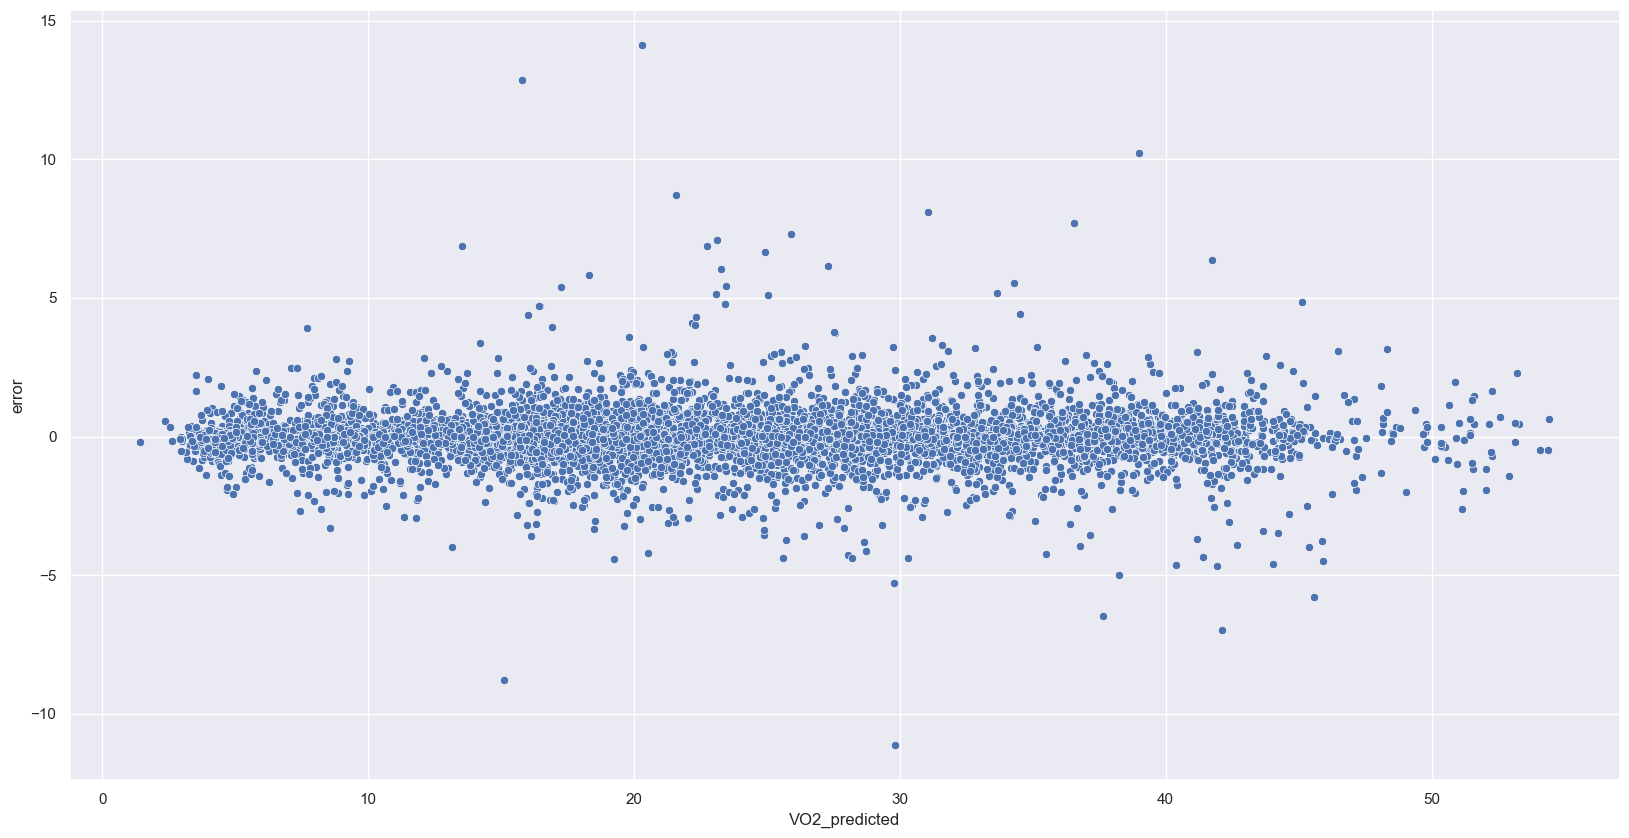

In [107]:
sns.scatterplot(x=df4_test['VO2_predicted'], y=df4_test['error']);


In [108]:
df4_test.sort_values(by='error', ascending=True).head(10)

,TestID,Time,FC,Idade,Peso,Altura,VO2,VO2_predicted,error
27286,10.0000,820.9120,185.1852,14.0000,58.8000,177.0000,18.6805,29.8046,-11.1241
18094,7.0000,14.7880,111.9403,15.0000,49.8000,165.0000,6.3406,15.1072,-8.7666
42484,15.0000,629.4160,172.4138,13.0000,63.5000,172.0000,35.1093,42.0988,-6.9895
45390,16.0000,730.2760,170.4545,16.0000,70.4000,182.0000,31.1785,37.6445,-6.4660
42796,15.0000,732.8920,185.1852,13.0000,63.5000,172.0000,39.7796,45.5619,-5.7823
37629,13.0000,1237.0160,172.4138,18.0000,83.9000,183.0000,24.5074,29.7916,-5.2841
26961,10.0000,713.0960,189.8734,14.0000,58.8000,177.0000,33.2500,38.2298,-4.9799
42497,15.0000,633.8680,178.5714,13.0000,63.5000,172.0000,37.2407,41.9142,-4.6735
37372,13.0000,1153.1160,187.5000,18.0000,83.9000,183.0000,35.7613,40.3951,-4.6339
33719,12.0000,1155.8240,185.1852,18.0000,86.0000,183.0000,39.4343,44.0405,-4.6063


In [111]:
df4_test.sort_values(by='error', ascending=False).head(10)

,TestID,Time,FC,Idade,Peso,Altura,VO2,VO2_predicted,error
21535,8.0000,581.2520,3.5902,15.0000,51.2000,165.0000,34.4335,20.3122,14.1214
45940,16.0000,916.2760,142.8571,16.0000,70.4000,182.0000,28.6422,15.7871,12.8551
17390,6.0000,890.7160,170.4545,17.0000,65.6000,169.0000,49.1997,38.9839,10.2158
43134,15.0000,840.5560,172.4138,13.0000,63.5000,172.0000,30.2920,21.5833,8.7086
33127,12.0000,955.4600,157.8947,18.0000,86.0000,183.0000,39.1567,31.0564,8.1002
33273,12.0000,1006.1440,170.4545,18.0000,86.0000,183.0000,44.2340,36.5387,7.6953
41746,15.0000,346.4920,140.1869,13.0000,63.5000,172.0000,33.2273,25.9079,7.3194
32620,12.0000,771.5680,144.2308,18.0000,86.0000,183.0000,30.2019,23.1122,7.0897
21128,8.0000,420.5840,78.9474,15.0000,51.2000,165.0000,29.6272,22.7440,6.8832
15404,6.0000,34.4720,108.6957,17.0000,65.6000,169.0000,20.3976,13.5371,6.8606


In [114]:
df4_test.groupby('TestID').mean().head(20)

,Time,FC,Idade,Peso,Altura,VO2,VO2_predicted,error
TestID,,,,,,,,
1.0000,409.8630,155.3526,15.0000,53.7000,161.0000,17.8990,17.8892,0.0098
2.0000,302.1834,138.1860,15.0000,56.2000,162.0000,19.1445,19.1389,0.0056
3.0000,668.2618,135.9296,16.0000,89.9000,191.0000,20.0045,19.9652,0.0393
4.0000,654.0722,148.1118,16.0000,76.5000,180.0000,20.7041,20.7076,-0.0035
5.0000,671.2314,145.8709,17.0000,76.4000,186.0000,24.1876,24.1391,0.0484
6.0000,525.0831,136.3740,17.0000,65.6000,169.0000,26.5244,26.4561,0.0683
7.0000,332.2694,144.5497,15.0000,49.8000,165.0000,17.2683,17.3138,-0.0455
8.0000,377.7948,138.7119,15.0000,51.2000,165.0000,21.7459,21.7757,-0.0298
9.0000,422.6316,154.1955,14.0000,57.1000,176.0000,17.7316,17.7045,0.0270
